<a href="https://colab.research.google.com/github/SaAPro/stock_analysis_pandas_scikit/blob/master/stock_analysis_pandas_scikit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock analysis with pandas and scikit libraries
In this notebook, we will see how to use three methods to forecast stock market prices and compare there results.

## Librairies
First, we import the librairies we will need.

In [0]:
import math
import numpy as np
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, HuberRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.linear_model import SGDRegressor
from sklearn.naive_bayes import ComplementNB
from sklearn import tree
from sklearn.neural_network import MLPRegressor

## Configuration
Some variable definitions to configure easily our program.

In [0]:
# Stock you want to analyse and predict
company = 'RI.PA'

# Period of study
period = 5*365 #in [days]
end = datetime.datetime.now()
start = end - datetime.timedelta(days=period)

# Rolling mean window
window = 20

# Size of the test sample in % of the full dataset
test_size = 0.1

# Prediction at +forecast_out days
forecast_out = 5

## Data import with pandas
Importation of the data via pandas_datareader tool

In [0]:
df = web.DataReader(company,'yahoo',start=start,end=end)
date = df.reset_index()['Date']
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-30,174.649994,171.000000,171.500000,173.699997,495254.0,173.699997
2019-09-02,177.449997,173.699997,173.750000,177.199997,377365.0,177.199997
2019-09-03,177.350006,176.000000,177.149994,177.250000,387062.0,177.250000
2019-09-04,179.500000,176.199997,179.350006,176.550003,413497.0,176.550003
2019-09-06,175.800003,173.100006,173.949997,174.750000,355367.0,174.750000


## Data display
Here we display some info such as close prices, rolling mean and return rate for the choosen stock

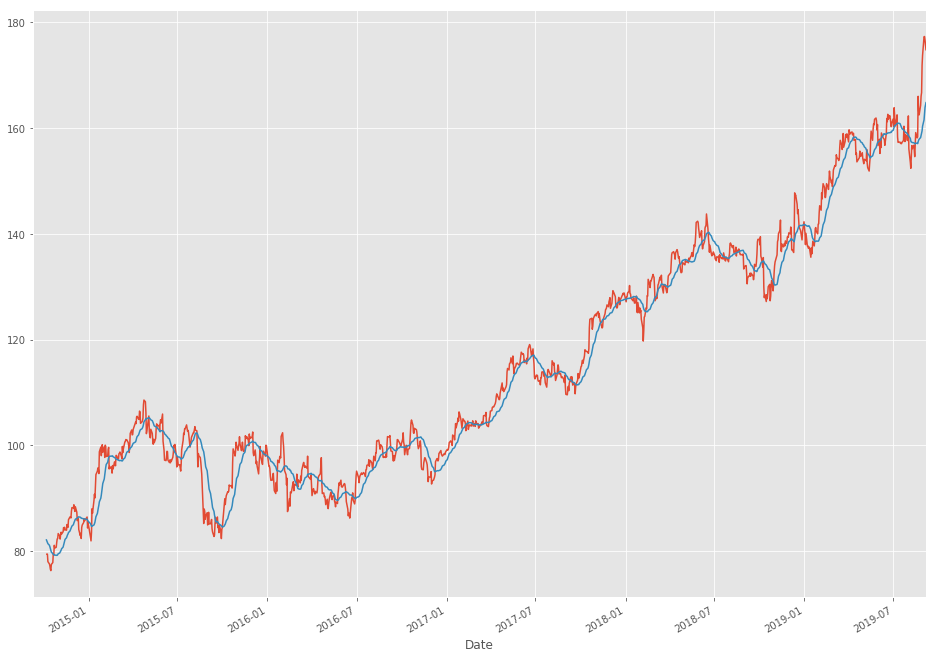

In [0]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=window).mean()
close_px = close_px[window:]

# Adjusting the size of matplotlib
mpl.rc('figure', figsize=(16, 12))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

# Close prices and mavg plot
close_px.plot(label=company)
mavg.plot(label='mavg')

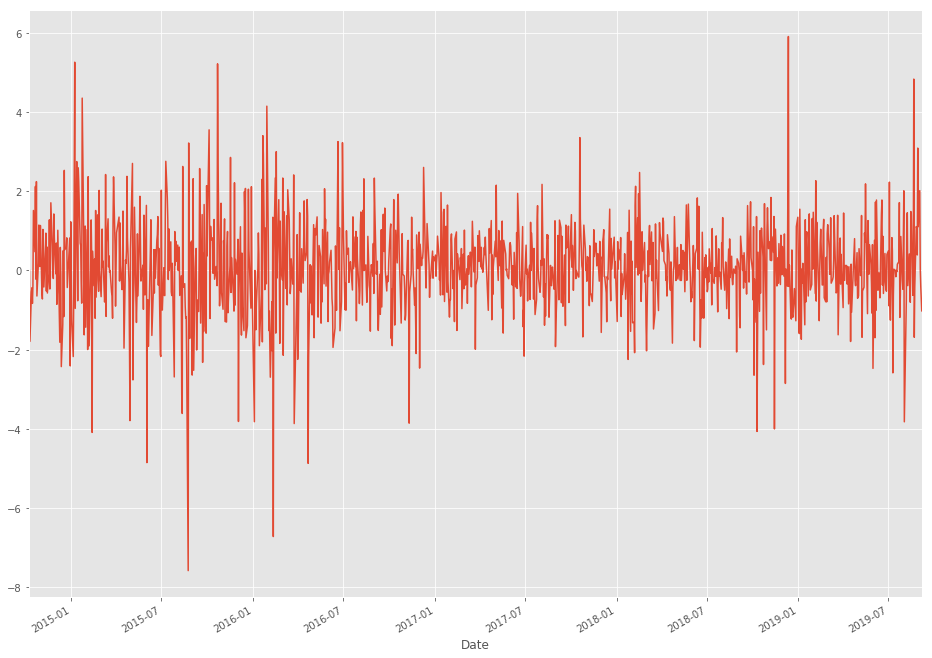

In [0]:
# Returns plot
rets = ( close_px / close_px.shift(1) - 1 ) * 100
rets.plot(label='returns')

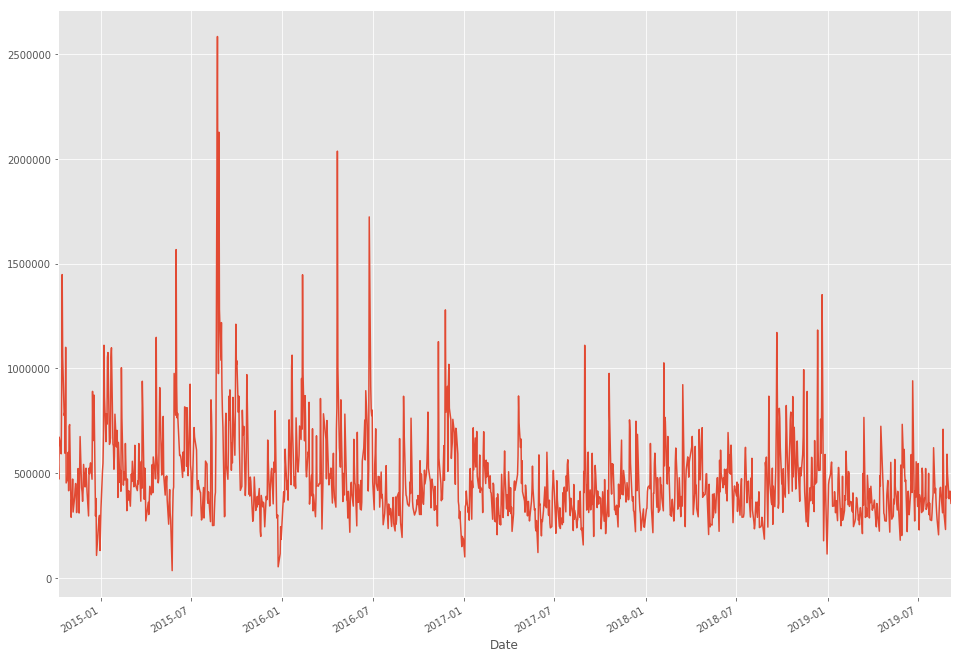

In [0]:
# Volume plot
volume = df['Volume'][window:]
volume.plot(label='volume')

## Stock prices prediction
### Inputs
In order to predict the prices of the stock, we are going to use :
* Adjusted closed price
* Adjusted volume
* High-low percentage
* Percentage change


In [0]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-08-30,173.699997,495254.0,2.101321,1.282797
2019-09-02,177.199997,377365.0,2.116253,1.985610
2019-09-03,177.250000,387062.0,0.761640,0.056453
2019-09-04,176.550003,413497.0,1.869161,-1.561195
2019-09-06,174.750000,355367.0,1.545063,0.459904


### Pre-processing & cross validation

In [0]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# Creating the label here, we want to predict the AdjClose in +forecast_out days
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)

# Drop the columns 'label' for X_
X_ = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X_ = preprocessing.scale(X_)

# Separate label and identify it as y
y = np.array(dfreg['label'])

# Define late X for the model forecast
X_lately = X_[-forecast_out:]

# Remove the tail of X_ and y corresponding to the shift of forecast_out
X = X_[:-forecast_out]
y = y[:-forecast_out]

print('Dimension of X',X.shape)
print('Dimension of y',y.shape)

Dimension of X (1270, 4)
Dimension of y (1270,)


In [0]:
# Separation of training and testing of model by cross validation train test split
X_train, X_test, y_train, y_test, date_train, date_test = train_test_split(X, y, date[:-forecast_out], test_size=test_size, random_state=42)

print('Dimension of X_train',X_train.shape)
print('Dimension of y_train',y_train.shape)
print('Dimension of X_test',X_test.shape)
print('Dimension of y_test',y_test.shape)

Dimension of X_train (1143, 4)
Dimension of y_train (1143,)
Dimension of X_test (127, 4)
Dimension of y_test (127,)


### Training the models

In [0]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), HuberRegressor())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), HuberRegressor())
clfpoly3.fit(X_train, y_train)
    
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

# Support Vector Regression
clfsvm = svm.SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)
clfsvm.fit(X_train, y_train)

# Stochastic Gradient Descent
clfsgd = SGDRegressor(loss="huber", max_iter=10000, tol=1e-3)
clfsgd.fit(X_train, y_train)

# Decision Tree Regression
clftree = tree.DecisionTreeRegressor()
clftree.fit(X_train, y_train)

# Multi-Layer Perceptron Regressor
clfmlp = MLPRegressor(activation='logistic', solver='lbfgs')
clfmlp.fit(X_train, y_train)

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

### Model confidence score
The confidence represents the mean accuracy on the given test data and labels.

In [0]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)
confidencesvm = clfsvm.score(X_test, y_test)
confidencesgd = clfsgd.score(X_test, y_test)
confidencetree = clftree.score(X_test, y_test)
confidencemlp = clfmlp.score(X_test, y_test)
  

print("The linear regression confidence is ",confidencereg)
print("The quadratic regression 2 confidence is ",confidencepoly2)
print("The quadratic regression 3 confidence is ",confidencepoly3)
print("The knn regression confidence is ",confidenceknn)
print("The svm regression confidence is ",confidencesvm)
print("The sgd regression confidence is ",confidencesgd)
print("The decision tree regression confidence is ",confidencetree)
print("The mlp regression confidence is ",confidencemlp)

The linear regression confidence is  0.9851194372786682
The quadratic regression 2 confidence is  0.9852250182435296
The quadratic regression 3 confidence is  0.9745185439961692
The knn regression confidence is  0.9632026332959621
The svm regression confidence is  0.9829149869804196
The sgd regression confidence is  0.9054750821466248
The decision tree regression confidence is  0.9688902808475452
The mlp regression confidence is  0.9840528146292414


The order-2 polynomial regression seems to performs the best with our dataset. The linear regression performs well too, followed by the support vector machines regression and the multi-layer perceptron regressor.

In [0]:
# Printing the forecast
forecast_set = clfpoly2.predict(X_lately)
print(forecast_set, confidencepoly2, forecast_out)

[174.24287153 177.07510396 177.54816786 177.80882393 175.34830578] 0.9852250182435296 5


## Results
Let's predict the adjusted closed price over the full period and compare it with the real values.

Text(0, 0.5, 'Price')

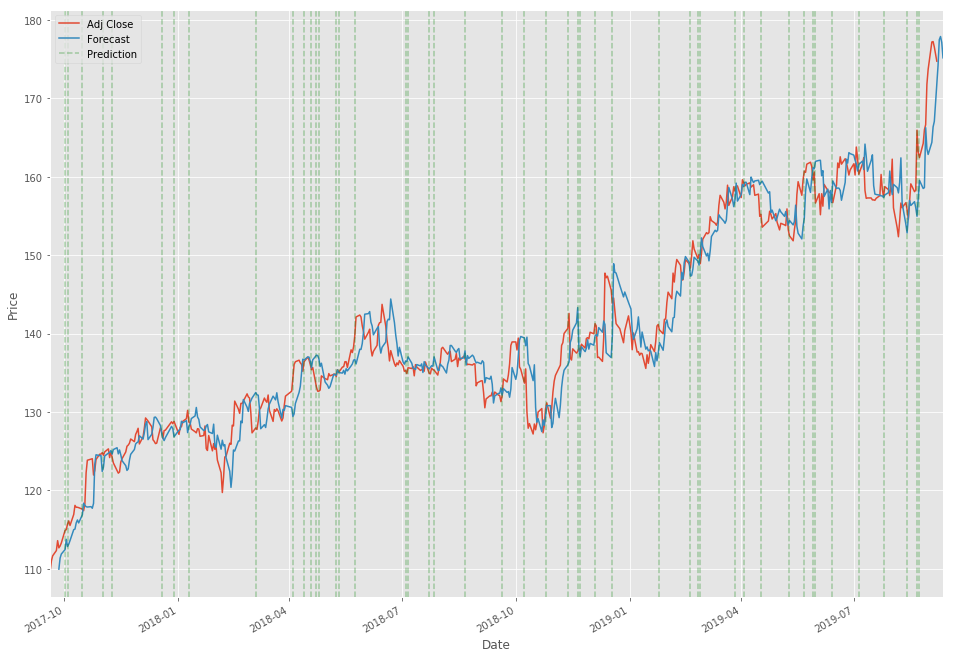

In [0]:
# Prediction
dfreg['Forecast'] = np.nan
dfreg.loc[:,'Forecast'] = clfreg.predict(X_)

last_date = dfreg.iloc[-1].name

for _ in range(forecast_out):
  last_date += datetime.timedelta(days=1)
  dfreg = dfreg.append(pd.DataFrame(index=[last_date]), sort=False)

dfreg['Forecast'] = dfreg['Forecast'].shift(forecast_out)

# Plot the results
df['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()

for xc in date_test:
  plt.axvline(x=xc, alpha=.3, linestyle='--', color='green')

plt.legend(('Adj Close', 'Forecast', 'Prediction'),loc='upper left')
plt.xlabel('Date')
plt.ylabel('Price')

The results don't match my expectations considering the confidence score we got in the previous section. The prediction seems to follow the adjusted price with a delay corresponding to the forecast_out.